## Fast Gradient Sign Attack


$$\mathbf{x} + \epsilon \text{sign}(\nabla_{\mathbf{x}} J(\theta, \mathbf{x}, y))$$

---

### Data

In [1]:
import torch 
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils import data

In [2]:
def get_dataloader_workers():
    return 4

In [3]:
def load_data_mnist(batch_size):
    trans = [transforms.ToTensor()]
    trans = transforms.Compose(trans)
    
    mnist_train = torchvision.datasets.MNIST(
        root="./data", train=True, transform=trans, download=True
    )
    mnist_test = torchvision.datasets.MNIST(
        root="./data", train=False, transform=trans, download=True
    )
    
    train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,
                                 num_workers = get_dataloader_workers())
    test_iter = data.DataLoader(mnist_test, batch_size, shuffle=True,
                                 num_workers = get_dataloader_workers())
    
    return train_iter, test_iter

### Model

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

Load the model

In [6]:
model = Net()
model.load_state_dict(torch.load('lenet_mnist_model.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

`model.eval()` is a kind of switch for some specific layers/parts of the model that behave differently during traing and inference (evaluating) time. For example, **Dropouts** kayers, batchnorm layers. Need to trun off them during model evaluation, and `.eval()` will do it.


During training, we need to turn it back using `model.train()`.

In [7]:
epsilons = [0, .05, .1, .15, .2, .25, .3]

In [9]:
def fgsm_attack(X, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_X = X + epsilon * sign_data_grad
    # adding clipping to maintain [0, 1] range
    perturbed_X = torch.clamp(perturbed_X, 0, 1)
    
    return perturbed_X

In [12]:
def test(model, test_iter, epsilon):
    correct = 0
    adv_examples = []
    
    for X, y in test_iter:
        X.requires_grad = True
        y_hat = model(X)
        _, predict = torch.max(y_hat.data, 1)
        if predict.item() != y:
            continue
        loss = F.nll_loss(y_hat, y)
        
        model.zero_grad()
        loss.backward()
        
        data_grad = X.grad.data
        
        perturbed_X = fgsm_attack(X, epsilon, data_grad)
        
        re_y_hat = model(perturbed_X)
        
        _, re_predict = torch.max(re_y_hat.data, 1)
        if re_predict.item() == y.item():
            correct += 1
            
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_X.squeeze().detach()
                adv_examples.append((predict.item(), re_predict.item(), adv_ex))
            else:
                if len(adv_examples) < 5:
                    adv_ex = perturbed_X.squeeze().detach()
                    adv_examples.append((predict.item(), re_predict.item(), adv_ex))
                    
    final_acc = correct/float(len(test_iter))
    print("Epsilon: {}\tTest Accuracy = {}/{}".format(epsilon, correct, len(test_iter), final_acc))

    return final_acc, adv_examples      

In [13]:
train_iter, test_iter = load_data_mnist(batch_size = 1)

accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, test_iter, eps)
    accuracies.append(acc)
    examples.append(ex)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Epsilon: 0	Test Accuracy = 9143/10000
Epsilon: 0.05	Test Accuracy = 8785/10000
Epsilon: 0.1	Test Accuracy = 8084/10000
Epsilon: 0.15	Test Accuracy = 6871/10000
Epsilon: 0.2	Test Accuracy = 5297/10000
Epsilon: 0.25	Test Accuracy = 3648/10000
Epsilon: 0.3	Test Accuracy = 2306/10000


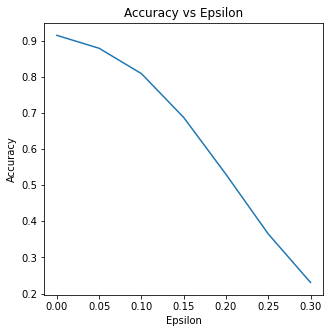

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(5, 5))
plt.plot(epsilons, accuracies)
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()